# Chron.jl standalone age-depth model with simple Gaussian age constraints

This Jupyter notebook executes an age-depth model for El Capitan using [Chron.jl](https://github.com/brenhinkeller/Chron.jl). For more information on the model, see [github.com/brenhinkeller/Chron.jl](https://github.com/brenhinkeller/Chron.jl) and [doi.org/10.17605/osf.io/TQX3F](https://doi.org/10.17605/osf.io/TQX3F). All age data inputs are summarized in Table SM1 of Anttila et al. (2023).
***

## Load required Julia packages

In [21]:
# Load (and install if necessary) the Chron.jl package
try
    using Chron
catch
    using Pkg
    Pkg.add("Chron")
    using Chron
end

using Statistics, StatsBase, DelimitedFiles, SpecialFunctions
using Plots; gr(); default(fmt = :png)

In [22]:
# Input the number of samples to be used in model, must match below.
nSamples = 16 #includes all 14 age constraints as detailed in Table SM1, plus two correlated samples (basal Tranquillon ash and a young biostrat constraint from John et al. (2002), used to provide constraints on either side of the section)

# Make an instance of a ChronSection object for nSamples
smpl = NewChronAgeData(nSamples)
smpl.Name          = ("Tranqillon","EAGC2010","EAGC2012","EAGC2011","EAGC2003","EAGC2006","EAGC2008","F1917-33.7","F1917_13.4","F1917_8.2","F1917_0.7","EAGC2009","EAGC2001","EAGC2002","M1801_.73", "upperbound, John 2002 FO discoaster pentaradiatus") #Sample names
smpl.Age           = [ 18.14,11.316,12.488,12.34,13.255,13.907,14.297,15.498,17.173,17.195,17.276,11.79,12.94,13.04,18.03,9.297] # Measured ages
smpl.Age_sigma     = [0.36,0.0851158,0.024,0.25,0.071,0.044,0.019,0.026,0.040,0.035,0.028,0.24,0.26,0.26,0.36,.75]/2 # Measured 2-σ uncertainties, divided by 2; chron.jl uses 1sigma uncertainties as input data
smpl.Height[:]     = [19,209.5,205.25,205.35,195,181.75,162,133.7,113.4,108.2,100.7,210,196.15,195.85,58.4,235] # Sample height in measured section
smpl.Height_sigma[:]  = [1.5,.01,.01,.01,.01,.01,.01,.01,.01,.01,.01,.01,.0,.01,.01,1.5] # Usually assume little or no sample height uncertainty; uncertainty added to constraints from correlated sections (in this case the top young calc-nannofossil constraint from John et al., 2002, used as a minimum age to anchor top of model, and putative basal "Tranquillon" ash). 
smpl.Age_Sidedness[:] = [0,0,0,0,-1,0,0,0,-1,0,0,-1,0,0,0,0] # Sidedness (zeros by default: geochron constraints are two-sided). Use -1 for a maximum age and +1 for a minimum age, 0 for two-sided
smpl.Path = "Output_ElCap/" # Output file path

smpl.Age_Unit = "Ma"; # Unit of measurement for ages
smpl.Height_Unit = "m"; # Unit of measurement for Height and Height_sigma

Note that smpl.Height *must* increase with increasing stratigraphic height -- i.e., stratigraphically younger samples must be more positive. For this reason, it is convenient to represent depths below surface as negative numbers.

***
## Configure and run stratigraphic model, no hiatuses

To run the stratigraphic MCMC model, we call the `StratMetropolis` function, which uses the Gaussian mean age and standard deviation set in `smpl.Age` and `smpl.Age_sigma`

Generating stratigraphic age-depth model...
Burn-in: 21620000 steps


Burn-in... 100%|█████████████████████████████████████████| Time: 0:00:26


Collecting... 100%|██████████████████████████████████████| Time: 0:01:34


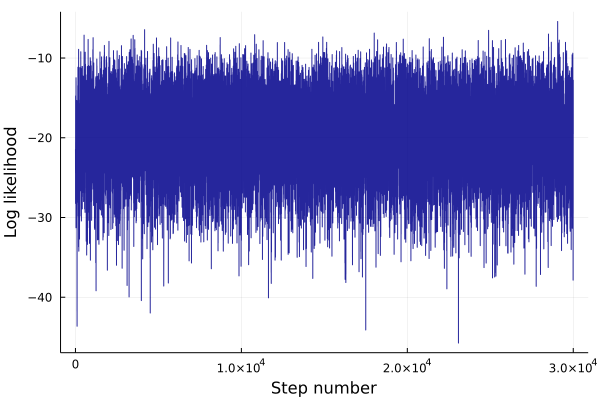

In [23]:
# Configure the stratigraphic Monte Carlo model
config = NewStratAgeModelConfiguration()
# If in doubt, you can probably leave these parameters as-is
config.resolution = 0.2 # Same units as sample height. Smaller is slower!
config.bounding = 0.5 # how far away do we place runaway bounds, as a fraction of total section height
(bottom, top) = extrema(smpl.Height)
npoints_approx = round(Int,length(bottom:config.resolution:top) * (1 + 2*config.bounding))
config.nsteps = 30000 # Number of steps to run in distribution MCMC
config.burnin = 10000*npoints_approx # Number to discard
config.sieve = round(Int,npoints_approx) # Record one out of every nsieve steps

# Run the stratigraphic MCMC model
(mdl, agedist, lldist) = StratMetropolis(smpl, config)

# Write the results to file
run(`mkdir -p $(smpl.Path)`) # Make sure that the path exists
writedlm(smpl.Path*"agedist.csv", agedist, ',') # Stationary distribution of the age-depth model
writedlm(smpl.Path*"height.csv", mdl.Height, ',') # Stratigraphic heights corresponding to each row of agedist
writedlm(smpl.Path*"age.csv", mdl.Age, ',') # Mean age of resulting model
writedlm(smpl.Path*"age_025CI.csv", mdl.Age_025CI, ',') # 2.5% confidence interval of resulting model
writedlm(smpl.Path*"age_975CI.csv", mdl.Age_975CI, ',') # 97.5% confidence interval of resulting model
writedlm(smpl.Path*"lldist.csv", lldist, ',') # Log likelihood distribution (to check for stationarity)

# Plot the log likelihood to make sure we're converged (n.b burnin isn't recorded)
hdl = plot(lldist,xlabel="Step number",ylabel="Log likelihood",label="",line=(0.85,:darkblue))
savefig(hdl,smpl.Path*"lldist.pdf")
display(hdl)

The most important output of this process is `agedist`, which contains the full stationary distribution of the age-depth model. We can save it to a file, but if this notebook is running remotely, you may have trouble getting it out of here (see section **Getting your data out**)!
***
## Plot results

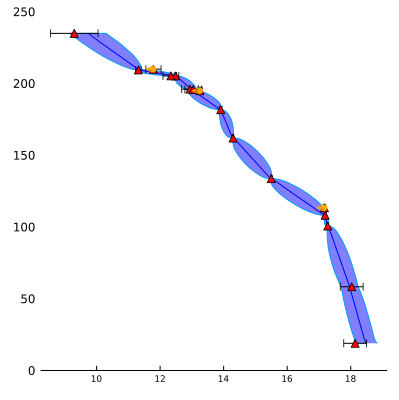

In [24]:
# Plot results (mean and 95% confidence interval for both model and data)
hdl = plot([mdl.Age_025CI; reverse(mdl.Age_975CI)],[mdl.Height; reverse(mdl.Height)], fill=(round(Int,minimum(mdl.Height)),0.5,:blue), label="")
plot!(hdl, mdl.Age, mdl.Height, linecolor=:blue, label="", fg_color_legend=:white) # Center line
t = smpl.Age_Sidedness .== 0 # Two-sided constraints (plot in black)
any(t) && plot!(hdl, smpl.Age, smpl.Height, xerror=smpl.Age_sigma*2,label="",seriestype=:scatter,markershape=:utriangle,color=:red)
t = smpl.Age_Sidedness .== 1 # Minimum ages (plot in cyan)
any(t) && plot!(hdl, smpl.Age[t], smpl.Height[t], xerror=(smpl.Age[t]-smpl.Age_025CI[t],zeros(count(t))),label="",seriestype=:scatter,color=:cyan,msc=:cyan)
any(t) && zip(smpl.Age[t], smpl.Age[t].+nanmean(smpl.Age_sigma[t])*4, smpl.Height[t]) .|> x-> plot!([x[1],x[2]],[x[3],x[3]], arrow=true, label="", color=:cyan)
t = smpl.Age_Sidedness .== -1 # Maximum ages (plot in orange)
any(t) && plot!(hdl, smpl.Age[t], smpl.Height[t], xerror=(zeros(count(t)),smpl.Age_975CI[t]-smpl.Age[t]),label="",seriestype=:scatter,color=:orange,msc=:orange)
any(t) && zip(smpl.Age[t], smpl.Age[t].-nanmean(smpl.Age_sigma[t])*4, smpl.Height[t]) .|> x-> plot!([x[1],x[2]],[x[3],x[3]], arrow=true, label="", color=:orange)
plot!(hdl, size=(400,400),ylims=(0,250), xtickfontsize=6,yaxis=false,grid=false)# ylabel="Height ($(smpl.Height_Unit))")
savefig(hdl,smpl.Path*"AgeDepthModel.svg")
savefig(hdl,smpl.Path*"AgeDepthModel_ElCap.pdf")
display(hdl)

In [25]:
#use age/height curve to solve for age of data heights for use in interpolated TOC plots, etc.

height = range(0,stop=240)

single_age_at_height = linterp1s(mdl.Height,mdl.Age,height)
writedlm(smpl.Path*"Age_at_height.csv", single_age_at_height, ',')

## Plot sedrate curve

  0.564048 seconds (777.45 k allocations: 917.777 MiB, 8.32% gc time)


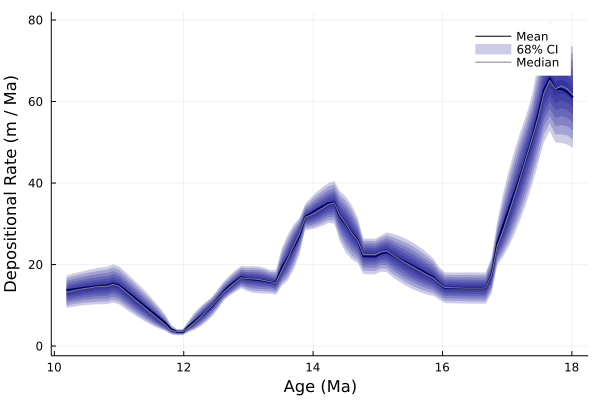

In [26]:
# Set bin width and spacing
binwidth = round(nanrange(mdl.Age)/10,sigdigits=1) # Can also set manually, commented out below
#binwidth = .5# Same units as smpl.Age
binoverlap = 10
ages = collect(minimum(mdl.Age):binwidth/binoverlap:maximum(mdl.Age))
bincenters = ages[1+Int(binoverlap/2):end-Int(binoverlap/2)]
spacing = binoverlap

# Calculate rates for the stratigraphy of each markov chain step
dhdt_dist = Array{Float64}(undef, length(ages)-binoverlap, config.nsteps)
@time for i=1:config.nsteps
    heights = linterp1(reverse(agedist[:,i]), reverse(mdl.Height), ages)
    dhdt_dist[:,i] .= abs.(heights[1:end-spacing] - heights[spacing+1:end]) ./ binwidth
end

# Find mean and 1-sigma (68%) CI
dhdt = nanmean(dhdt_dist,dim=2)
dhdt_50p = nanmedian(dhdt_dist,dim=2)
dhdt_16p = nanpctile(dhdt_dist,15.865,dim=2) # Minus 1-sigma (15.865th percentile)
dhdt_84p = nanpctile(dhdt_dist,84.135,dim=2) # Plus 1-sigma (84.135th percentile)
# Other confidence intervals (10:10:50)
dhdt_20p = nanpctile(dhdt_dist,20,dim=2)
dhdt_80p = nanpctile(dhdt_dist,80,dim=2)
dhdt_25p = nanpctile(dhdt_dist,25,dim=2)
dhdt_75p = nanpctile(dhdt_dist,75,dim=2)
dhdt_30p = nanpctile(dhdt_dist,30,dim=2)
dhdt_70p = nanpctile(dhdt_dist,70,dim=2)
dhdt_35p = nanpctile(dhdt_dist,35,dim=2)
dhdt_65p = nanpctile(dhdt_dist,65,dim=2)
dhdt_40p = nanpctile(dhdt_dist,40,dim=2)
dhdt_60p = nanpctile(dhdt_dist,60,dim=2)
dhdt_45p = nanpctile(dhdt_dist,45,dim=2)
dhdt_55p = nanpctile(dhdt_dist,55,dim=2)

# Plot results
hdl = plot(bincenters,dhdt, label="Mean", color=:black, linewidth=2)
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_16p; reverse(dhdt_84p)], fill=(0,0.2,:darkblue), linealpha=0, label="68% CI")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_20p; reverse(dhdt_80p)], fill=(0,0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_25p; reverse(dhdt_75p)], fill=(0,0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_30p; reverse(dhdt_70p)], fill=(0,0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_35p; reverse(dhdt_65p)], fill=(0,0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_40p; reverse(dhdt_60p)], fill=(0,0.2,:darkblue), linealpha=0, label="")
plot!(hdl,[bincenters; reverse(bincenters)],[dhdt_45p; reverse(dhdt_55p)], fill=(0,0.2,:darkblue), linealpha=0, label="")
plot!(hdl,bincenters,dhdt_50p, label="Median", color=:grey, linewidth=1)
plot!(hdl, xlabel="Age ($(smpl.Age_Unit))", ylabel="Depositional Rate ($(smpl.Height_Unit) / $(smpl.Age_Unit))", fg_color_legend=:white)
savefig(hdl,smpl.Path*"DepositionRateModelCI_ElCap.pdf")
display(hdl)


writedlm(smpl.Path*"ElCap_bincenters.csv", bincenters, ',')
writedlm(smpl.Path*"ElCap_dhdt.csv", dhdt, ',')
writedlm(smpl.Path*"ElCap_dhdt_50.csv", dhdt_50p, ',')
writedlm(smpl.Path*"ElCap_dhdt_16.csv", dhdt_16p, ',')
writedlm(smpl.Path*"ElCap_dhdt_84.csv", dhdt_84p, ',')



In [27]:
#use age/height curve to solve for age of data heights for use in interpolated TOC plots, etc.

height = [0.1
0.8
1.6
2.2
3.6
4
4.5
4.6
4.8
5.1
5.3
5.5
5.7
5.8
6
7.1
7.3
7.5
7.6
7.8
8.1
8.3
8.4
8.5
8.6
8.7
9
9.4
9.9
10.3
10.7
11.3
22
22.5
23
23.4
24
24.3
24.6
25
25.3
38.2
39
39.9
40.7
41.7
42.8
43.8
44.8
45.8
46.7
47.6
48.4
49.6
50.6
51.4
52.1
54.7
55.4
56.6
58.5
58.8
59.1
59.4
59.8
60.1
60.3
60.6
60.9
61.3
61.7
62
62.2
62.5
63
63.5
63.5
63.7
64.1
64.4
64.6
65
65.4
66
66.2
66.7
67
67.7
67.9
68.4
68.7
69.2
69.6
70.2
70.6
70.9
71.2
71.6
72.2
72.6
73
73.4
73.9
74.4
74.7
75.3
75.6626506
75.8
76.3
76.7
77.3
77.9
77.97590361
78.5
78.55421687
79.13253012
79.2
79.9
80.8
80.86746988
81.1
81.4
81.9
82.4
82.8
82.89156627
83.6
84.1
84.8
84.91566265
85.1
85.7
86.4
87.1
87.2
87.51807229
87.6
88.1
89.25301205
95.03614458
97.06024096
99.37349398
100.1
101.3975904
102.2
103.1
103.4216867
103.8
104.3
105
105.4457831
105.8
106.1
106.9
107.4
107.8
108.3
109.2048193
110.5
111.8072289
113.5
114.9879518
115.2771084
117.0120482
119.9036145
120
121.8
123.4
124.8192771
125.1
127
129
129.7349398
130
131.7590361
131.8
132.8
134.0722892
134.7
135.4
136.0963855
136.5
137.7
138.4096386
138.5
139.5
140.4337349
142
142.4578313
142.5
143.5
144.4819277
144.5
145.3
146.7951807
148.4
148.8192771
150.2
150.5542169
150.8
151
151.1
151.4
151.7
152
152.3
152.6
152.8674699
153.2
153.5
154.1
154.4
154.7
155
155.3
155.4698795
155.6
155.9
156.2
156.5
156.8
157
157.1
157.4939759
157.8
158.1
158.4
158.7
159
159.2289157
159.3
159.6
159.9
160.2
160.5
160.8
161.1
161.4
161.5421687
161.7
162
162.3
162.6
162.9
163.2
163.2771084
163.8
164.1
164.4
164.7
165
165.3
165.5903614
165.6
165.9
166.2
166.5
166.8
167.1
167.4
167.6144578
167.7
168
168.3
168.6
168.9
169.2
169.3493976
169.5
169.8
170.1
170.2168675
170.7
171
171.3
171.373494
171.6
171.6626506
172.2409639
172.5301205
172.5301205
173.2
173.3975904
173.5
173.8
173.9759036
174.2650602
174.4
174.5542169
174.7
175
175.3
175.4
175.4216867
175.4216867
175.6
175.7108434
175.9
176.2
176.5
176.8
177.1
177.1566265
177.4
177.4457831
177.7
178
178.3
178.313253
178.6
178.8915663
178.9
178.9
179.2
179.5
179.7590361
179.8
180.1
180.3373494
180.4
180.626506
180.9156627
181
181.3
181.4939759
181.6
181.7831325
181.9
182.2
182.3614458
182.5
182.6506024
183.2289157
183.5180723
184.0963855
184.6746988
184.9
185.5
185.5421687
185.5421687
185.8
186.1
186.4
186.4096386
186.7
186.9879518
187
187.2771084
187.3
187.6
187.9
188.1445783
188.2
188.5
188.7228916
188.8
189.1
189.4
189.5903614
189.5903614
189.7
189.8795181
190
190.1686747
190.1686747
190.4578313
191.0361446
191.2
191.3253012
191.5
191.8
192.1
192.1927711
192.4
192.4819277
192.4819277
192.7
193
193.060241
193.3493976
193.6
193.9
194.2
194.2168675
194.7951807
195.373494
195.6626506
195.7
196
196.5301205
196.6
196.9
197.1084337
197.2
197.5
197.8
197.9759036
198.1
198.2650602
198.2650602
198.5
199
199.4216867
199.5
199.7108434
200
200.5783133
200.8674699
201
201.5
201.7349398
202
202.5
202.8915663
203
204.5
205
205.5
205.7831325
206
206.5
209.8313253
212.1445783
214.1686747
215.9036145
218.5060241
220.2409639
221.686747
224]

single_age_at_height = linterp1s(mdl.Height,mdl.Age,height)
writedlm(smpl.Path*"Age_at_height_ElCapTOC.csv", single_age_at_height, ',')

In [28]:
#use age/height curve to solve for age of data heights for use in TOC vs XRF crossplots

height = [0.1
0.8
1.6
2.2
3.6
4
4.5
4.6
4.8
5.1
5.3
5.5
5.7
5.8
6
7.1
7.3
7.5
7.6
7.8
8.1
8.3
8.4
8.5
8.6
8.7
9
9.4
9.9
10.3
10.7
11.3
22
22.5
23
23.4
24
24.3
24.6
25
25.3
38.2
39
39.9
40.7
41.7
42.8
43.8
44.8
45.8
46.7
47.6
48.4
49.6
50.6
51.4
52.1
54.7
55.4
56.6
58.5
58.8
59.1
59.4
59.8
60.1
60.3
60.6
60.9
61.3
61.7
62
62.2
62.5
63
63.5
63.5
63.7
64.1
64.4
64.6
65
65.4
66
66.2
66.7
67
67.7
67.9
68.4
68.7
69.2
69.6
70.2
70.6
70.9
71.2
71.6
72.2
72.6
73
73.4
73.9
74.4
74.7
75.3
75.8
76.3
76.7
77.3
77.9
78.5
79.2
79.9
80.8
81.1
81.4
81.9
82.4
82.8
83.6
84.1
84.8
85.1
85.7
86.4
87.2
87.6
88.1
100.1
102.2
103.1
103.8
104.3
105.8
106.1
107.8
108.3
110.5
113.5
120
121.8
123.4
125.1
127
129
130
131.8
134.7
135.4
136.5
137.7
138.5
139.5
142
142.5
143.5
144.5
145.3
148.4
150.2
150.8
151
151.1
151.4
151.7
152
152.3
152.6
153.2
153.5
154.1
154.4
154.7
155
155.3
155.6
155.9
156.2
156.5
156.8
157
157.1
157.8
158.1
158.4
158.7
159
159.3
159.6
159.9
160.2
160.5
160.8
161.1
161.4
161.7
162
162.3
162.6
162.9
163.2
163.8
164.1
164.4
164.7
165
165.3
165.6
165.9
166.2
166.5
166.8
167.1
167.4
167.7
168
168.3
168.6
168.9
169.2
169.5
169.8
170.1
170.7
171
171.3
171.6
173.2
173.5
173.8
174.4
174.7
175
175.3
175.4
175.6
175.9
176.2
176.5
176.8
177.1
177.4
177.7
178
178.3
178.6
178.9
178.9
179.2
179.5
179.8
180.1
180.4
181
181.3
181.6
181.9
182.2
182.5
184.9
185.5
185.8
186.1
186.4
186.7
187
187.3
187.6
187.9
188.2
188.5
188.8
189.1
189.4
189.7
190
191.2
191.5
191.8
192.1
192.4
192.7
193
193.6
193.9
194.2
195.7
196
196.6
196.9
197.2
197.5
197.8
198.1
198.5
199
199.5
200
201
201.5
202
202.5
203
204.5
205
205.5
206
206.5]

single_age_at_height = linterp1s(mdl.Height,mdl.Age,height)
writedlm(smpl.Path*"Age_at_height_XRF.csv", single_age_at_height, ',')